In [1]:
#preprocessing permite trabajar el minmaxscaler
from sklearn import preprocessing
# mse para calcular el mse
from sklearn.metrics import mean_absolute_error
#load_model para leer el modelo :v
from keras.models import load_model
#jolib permite leer el scaler que se usó para y
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math

# lee el modelo
fit1 = load_model('lstm.h5')
fit2 = load_model('lstms.h5')
fit3 = load_model('lstm_s.h5')
fit4 = load_model('lstm_ss.h5')
fit5 = load_model('grus.h5')
# lee el scaler
scaler_y = joblib.load('scaler.save')
# presenta la arquitectura del modelo

C:\Users\Jergb\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Definir un algoritmo para acomodar los datos entrada al formato de la RNN
Y mostrar resultados :v 

### Se tiene que crear un scaler para los datos, hacer la predicción y luego invertir el scaler.
A ver cómo mola

In [2]:
nodo = 3
periodo =2
df1 = pd.read_csv('nodo%d_periodo%d.csv'%(nodo,periodo),parse_dates=True,index_col=0)
#df1['TIEMPO'] = df1.index.hour*60+df.index.minute
#df.info()
inicio = df1.index[0]
fin =df1.index[-1]

df = pd.read_csv('medidas_nodo%d.csv'%nodo,parse_dates=True,index_col=0)
df['faltante'] = 0
df = df.loc[inicio:fin,:]
df = df.asfreq('60s')
df['faltante'][df['faltante'].isnull()==True] = 1
df = df.ffill().bfill()
display(df.head())
df.info()

,HUMEDAD DE LA TIERRA,HUMEDAD RELATIVA,INTENSIDAD LUMÍNICA,NIVEL UV,TEMPERATURA,faltante
TIME,,,,,,
2018-05-23 10:08:00,98.88,33.0,5788.0,0.0,30.0,0.0
2018-05-23 10:09:00,98.56,33.0,5788.0,0.0,30.0,0.0
2018-05-23 10:10:00,98.56,33.0,5788.0,0.0,30.0,0.0
2018-05-23 10:11:00,98.56,33.0,5788.0,0.0,30.0,0.0
2018-05-23 10:12:00,98.56,33.0,5788.0,0.0,30.0,1.0


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4133 entries, 2018-05-23 10:08:00 to 2018-05-26 07:00:00
Freq: 60S
Data columns (total 6 columns):
HUMEDAD DE LA TIERRA    4133 non-null float64
HUMEDAD RELATIVA        4133 non-null float64
INTENSIDAD LUMÍNICA     4133 non-null float64
NIVEL UV                4133 non-null float64
TEMPERATURA             4133 non-null float64
faltante                4133 non-null float64
dtypes: float64(6)
memory usage: 226.0 KB


In [3]:
# Crear los datos de entrada y salida...
# Dtos base para la matriz de entrada
xbase = df.iloc[:,[1,4,5]].copy()
#xbase['TIME'] = df.iloc[:,1].values-df.iloc[:,3].values
y = df.iloc[:,[1,4]].copy()
# catarcetristicas, ventana (tiempo), objetivos 
cts = 3
ventana = 6
objetivos = 2
x = pd.DataFrame(index=xbase.index)
c =xbase.columns
for i in range(ventana):
    for j in c:
        x[j[0:2]+str(i)] = xbase.loc[:,j].shift(i+1)

display(x.head(6))
x = x.dropna()
display(x.head(6))
display(x.tail(6))

,HU0,TE0,fa0,HU1,TE1,fa1,HU2,TE2,fa2,HU3,TE3,fa3,HU4,TE4,fa4,HU5,TE5,fa5
TIME,,,,,,,,,,,,,,,,,,
2018-05-23 10:08:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-23 10:09:00,33.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-23 10:10:00,33.0,30.0,0.0,33.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-23 10:11:00,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-23 10:12:00,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-05-23 10:13:00,33.0,30.0,1.0,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,NaN,NaN,NaN


,HU0,TE0,fa0,HU1,TE1,fa1,HU2,TE2,fa2,HU3,TE3,fa3,HU4,TE4,fa4,HU5,TE5,fa5
TIME,,,,,,,,,,,,,,,,,,
2018-05-23 10:14:00,33.0,30.0,0.0,33.0,30.0,1.0,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0
2018-05-23 10:15:00,34.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,1.0,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0
2018-05-23 10:16:00,34.0,30.0,0.0,34.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,1.0,33.0,30.0,0.0,33.0,30.0,0.0
2018-05-23 10:17:00,33.0,30.0,0.0,34.0,30.0,0.0,34.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,1.0,33.0,30.0,0.0
2018-05-23 10:18:00,33.0,30.0,0.0,33.0,30.0,0.0,34.0,30.0,0.0,34.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,1.0
2018-05-23 10:19:00,33.0,30.0,0.0,33.0,30.0,0.0,33.0,30.0,0.0,34.0,30.0,0.0,34.0,30.0,0.0,33.0,30.0,0.0


,HU0,TE0,fa0,HU1,TE1,fa1,HU2,TE2,fa2,HU3,TE3,fa3,HU4,TE4,fa4,HU5,TE5,fa5
TIME,,,,,,,,,,,,,,,,,,
2018-05-26 06:55:00,54.0,27.0,0.0,55.0,26.0,0.0,56.0,26.0,0.0,56.0,26.0,0.0,56.0,26.0,0.0,56.0,26.0,0.0
2018-05-26 06:56:00,53.0,27.0,0.0,54.0,27.0,0.0,55.0,26.0,0.0,56.0,26.0,0.0,56.0,26.0,0.0,56.0,26.0,0.0
2018-05-26 06:57:00,53.0,27.0,0.0,53.0,27.0,0.0,54.0,27.0,0.0,55.0,26.0,0.0,56.0,26.0,0.0,56.0,26.0,0.0
2018-05-26 06:58:00,53.0,27.0,0.0,53.0,27.0,0.0,53.0,27.0,0.0,54.0,27.0,0.0,55.0,26.0,0.0,56.0,26.0,0.0
2018-05-26 06:59:00,53.0,27.0,0.0,53.0,27.0,0.0,53.0,27.0,0.0,53.0,27.0,0.0,54.0,27.0,0.0,55.0,26.0,0.0
2018-05-26 07:00:00,53.0,27.0,0.0,53.0,27.0,0.0,53.0,27.0,0.0,53.0,27.0,0.0,53.0,27.0,0.0,54.0,27.0,0.0


In [4]:
# Se define un scaler para los datos de entrada
scaler_x = preprocessing.MinMaxScaler(feature_range=(0,1))

In [5]:
# PAsa los datos a un arreglo de floats64 y los normaliza
x = np.array(x).reshape(len(x),ventana*cts)
x = scaler_x.fit_transform(x)

# Ajusta los datos a la forma de entrda del modelo
#x = np.array(x).reshape(len(x),ventana,1)
x=np.reshape(x,(x.shape[0],ventana,cts))
y = y[ventana:].values
y = np.array(y).reshape((len(y),objetivos))
display(x.shape,y.shape)

(4127, 6, 3)

(4127, 2)

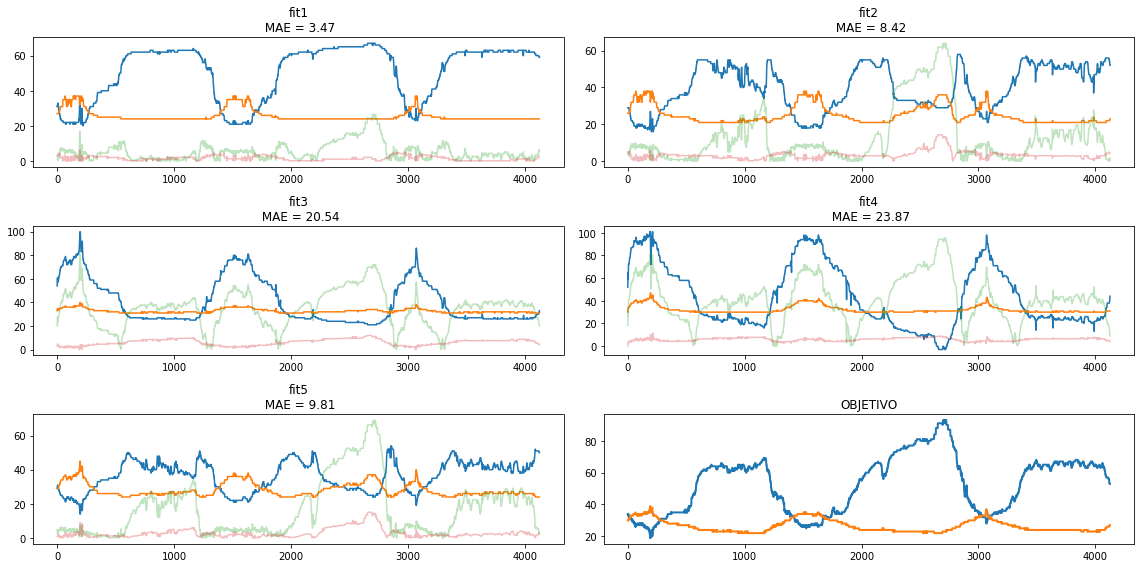

In [6]:
#y_ = scaler_y.inverse_transform(np.array(y).reshape((len(y),1)))
plt.figure(figsize=[16,8])
plt.subplot(3,2,6)
plt.plot(y,label='set de prueba',linewidth=2)
plt.title('OBJETIVO')

for i in [1,2,5]:
    plt.subplot(3,2,i)
    f = vars()[('fit%s')%str(i)]
    p = f.predict(x)
    p = vars()[('pred%s')%str(i)] = scaler_y.\
    inverse_transform(np.array(p).reshape((len(p),objetivos)))
    p1 = mean_absolute_error(p, y)
    plt.plot(np.rint(p))
    plt.plot(abs(p-y),alpha=.3)
    plt.title('fit%d\n MAE = %.2f'%(i,p1))

for i in [3,4]:
    plt.subplot(3,2,i)
    f = vars()[('fit%s')%str(i)]
    p = f.predict(x,batch_size=1)
    p = vars()[('pred%s')%str(i)] = scaler_y.\
    inverse_transform(np.array(p).reshape((len(p),objetivos)))
    p1 = mean_absolute_error(p, y)
    plt.plot(np.rint(p),label='sda')
    plt.title('fit%d\n MAE = %.2f'%(i,p1))
    plt.plot(abs(p-y),alpha=.3)
plt.tight_layout()

In [7]:
# Calcula el RMSE
for i in range(1,6):
    p = vars()[('pred%s')%str(i)]
    vars()[('mae%s')%str(i)] = mean_absolute_error(p, y)

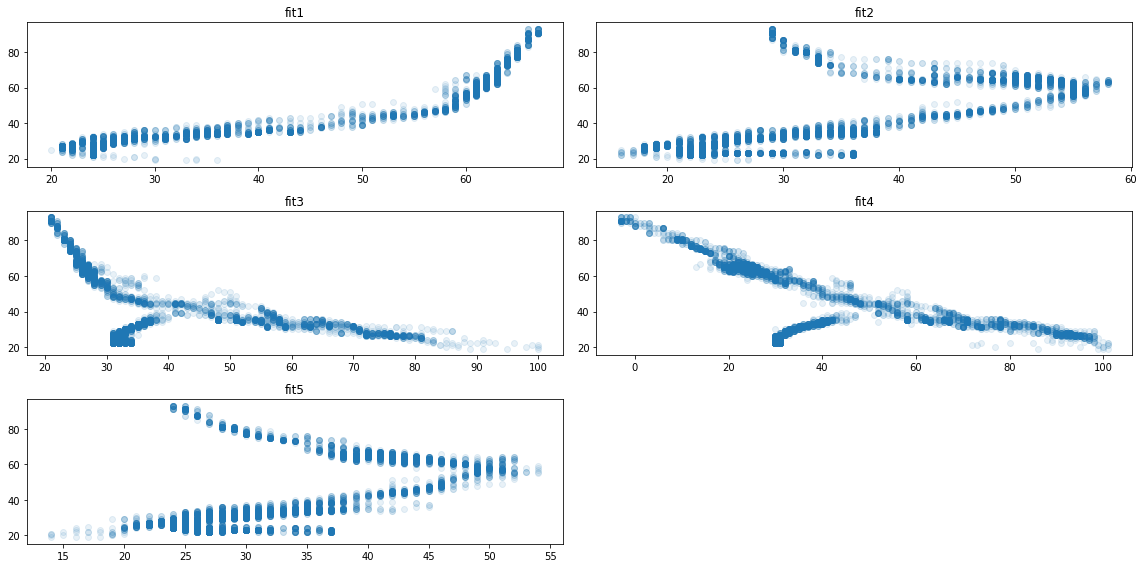

In [8]:
plt.figure(figsize=[16,8])
for i in range(1,6):
    plt.subplot(3,2,i)
    p = vars()[('pred%s')%str(i)]
    plt.scatter(np.rint(p),np.rint(y),alpha=.1)
    plt.title('fit%d'%i)
plt.tight_layout()

In [9]:
VAmo a probar con todos los datos a ve qué pasa y también probar metiendo los datos uno a uno ;D

SyntaxError: invalid syntax (<ipython-input-9-492349f33dba>, line 1)

In [ ]:
7.63,7.63,7.51